# Analysis of Embeddings from the SAM2 encoder
J. Cristiano      
This notebook is meant to explore the idea of using the SAM2 encoder to generate emmbeddings of the images and generate 3D projections for clustering.

In [1]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
from PIL import Image
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [2]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/opt/sam2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

From what I've been reading the tiny model is the most performant. 

In [3]:
ref_image_name = "8-16_38"
ref_image = Image.open('/work/rp_sync/2023/' + ref_image_name + ".jpg")
ref_image = np.array(ref_image.convert("RGB"))
predictor.set_image(ref_image)

In [4]:
ref_embedding = predictor.get_image_embedding()

In [5]:
import glob
import cv2
image_path_list = glob.glob('/work/rp_sync/2023/*.jpg')
image_list = [cv2.resize(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), ref_image.shape[:2]) for image_path in image_path_list]
image_array = np.stack(image_list)
predictor.set_image_batch(image_list[:10])

In [14]:
list_of_embeddings = predictor.get_image_embedding()
print(list_of_embeddings.shape)
list_embedding_reshaped = list_of_embeddings[:].view(list_of_embeddings[:].size(0), -1)

torch.Size([10, 256, 64, 64])


In [6]:
!pip install umap-learn


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [7]:
print(ref_embedding.shape)
# Reshape to 2D
ref_embedding_reshaped = ref_embedding.view(ref_embedding.size(0), -1)

# Verify the new shape
print(ref_embedding_reshaped.shape)  # Should print (1, 256 * 64 * 64)


torch.Size([1, 256, 64, 64])
torch.Size([1, 1048576])


In [17]:
pprint(projections)

array([[ 7.543586 , 16.164547 ,  8.560671 ],
       [ 8.284606 , 16.110872 , 10.3371105],
       [ 8.514517 , 15.181739 ,  9.994113 ],
       [ 7.04696  , 16.22718  ,  9.804083 ],
       [ 7.6154284, 15.177009 , 10.266225 ],
       [ 8.052967 , 16.378916 ,  9.228598 ],
       [ 7.6059685, 16.117586 , 10.636342 ],
       [ 8.574911 , 15.2918415,  9.084135 ],
       [ 7.0541277, 15.44033  ,  9.183723 ],
       [ 7.5594196, 15.466855 ,  8.307583 ]], dtype=float32)


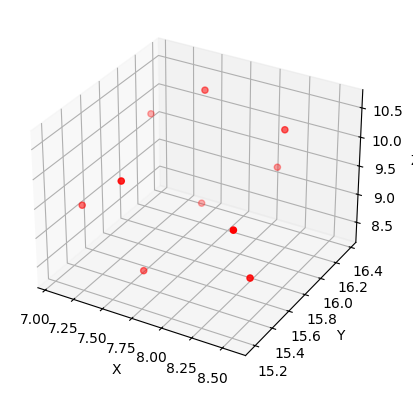

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = projections[:, 0]
y = projections[:, 1]
z = projections[:, 2]

ax.scatter3D(x, y, z, c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

lets try cosine similarity

In [18]:
def normalize(vec: np.ndarray):
    return vec / np.linalg.norm(vec, axis=1, keepdims=True)
normalized_embeddings = normalize(list_embedding_reshaped.cpu())
cosine_sim_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)

In [20]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 33.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [23]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(z=cosine_sim_matrix, colorscale='Viridis'))

fig.update_layout(
    title="Cosine Similarity Matrix",
    xaxis_title="Image Index",
    yaxis_title="Image Index",
    font=dict(size=14),
    width=750,
    height=750,
    margin=dict(t=100, r=100, b=100, l=100),
)

fig.show()

Cosine similarity to the reference image

In [30]:
normalized_reference = normalize(ref_embedding_reshaped.cpu())
cosine_sim_matrix = np.dot(normalized_reference, normalized_embeddings[:].T)

In [31]:
fig = go.Figure(data=go.Heatmap(z=cosine_sim_matrix, colorscale='Viridis'))

fig.update_layout(
    title="Cosine Similarity Matrix",
    xaxis_title="Image Index",
    yaxis_title="Image Index",
    font=dict(size=14),
    width=750,
    height=750,
    margin=dict(t=100, r=100, b=100, l=100),
)

fig.show()

In [27]:
pprint(image_path_list[:10])

['/work/rp_sync/2023/7-25_51.jpg',
 '/work/rp_sync/2023/9-22_185.jpg',
 '/work/rp_sync/2023/8-16_37.jpg',
 '/work/rp_sync/2023/8-25_271.jpg',
 '/work/rp_sync/2023/9-04_396.jpg',
 '/work/rp_sync/2023/7-25_37.jpg',
 '/work/rp_sync/2023/9-04_192.jpg',
 '/work/rp_sync/2023/8-16_19.jpg',
 '/work/rp_sync/2023/8-25_143.jpg',
 '/work/rp_sync/2023/9-04_127.jpg']
